# Time Series Forecasting of Telemetry Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os.path import exists
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
import matplotlib.dates as mdates
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow.keras.losses as loss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
errors = pd.read_csv('PdM_errors.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')
maintenance = pd.read_csv('PdM_maint.csv')
telemetry = pd.read_csv('PdM_telemetry.csv')

In [4]:
# Converting the dateime column in all the files to datetime data type.
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

Let us take a look at the errors of machine 1 and the corresponding dates

In [5]:
error_dates_1 = errors[errors['machineID']==1]['datetime'].dt.date
error_dates_1

0     2015-01-03
1     2015-01-03
2     2015-01-04
3     2015-01-10
4     2015-01-22
5     2015-01-25
6     2015-01-27
7     2015-03-03
8     2015-03-05
9     2015-03-20
10    2015-03-26
11    2015-03-31
12    2015-04-19
13    2015-04-19
14    2015-04-29
15    2015-05-04
16    2015-05-12
17    2015-05-21
18    2015-05-24
19    2015-05-25
20    2015-06-09
21    2015-06-18
22    2015-06-23
23    2015-08-23
24    2015-08-30
25    2015-09-01
26    2015-09-13
27    2015-09-15
28    2015-10-01
29    2015-10-15
30    2015-10-16
31    2015-10-16
32    2015-10-16
33    2015-11-10
34    2015-12-15
Name: datetime, dtype: object

In [6]:
# Similarly, we will take a look at the failures of machine 1 and the corresponding dates
failure_dates_1 = failures[failures['machineID']==1]['datetime'].dt.date
failure_dates_1

0    2015-01-05
1    2015-03-06
2    2015-04-20
3    2015-06-19
4    2015-09-02
5    2015-10-17
6    2015-12-16
Name: datetime, dtype: object

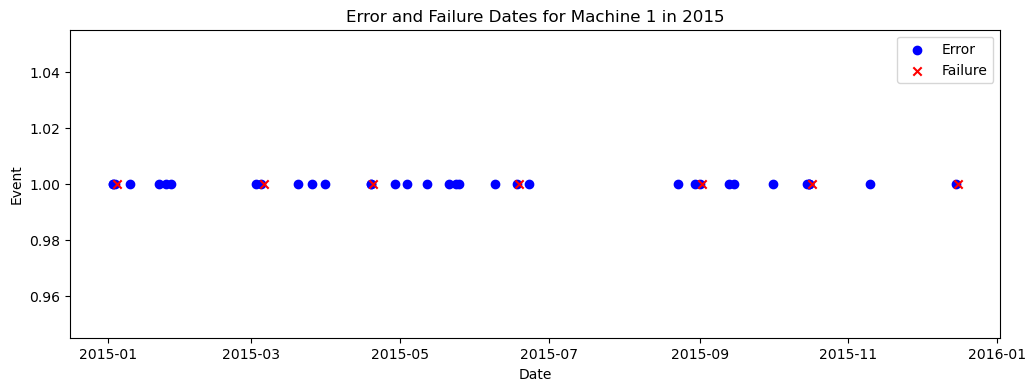

In [7]:
import matplotlib.pyplot as plt

# Convert date strings to datetime objects
error_dates_1 = pd.to_datetime(error_dates_1)
failure_dates_1 = pd.to_datetime(failure_dates_1)

plt.figure(figsize=(12, 4))
# Create a plot with blue markers for errors and red markers for failures
plt.scatter(error_dates_1, [1] * len(error_dates_1), color='blue', marker='o', label='Error')
plt.scatter(failure_dates_1, [1] * len(failure_dates_1), color='red', marker='x', label='Failure')

# Set plot labels and legend
plt.xlabel('Date')
plt.ylabel('Event')
plt.title('Error and Failure Dates for Machine 1 in 2015')
plt.legend()

# Show the plot
plt.show()

It can be seen that every failure is preceeded by one or more errors. So, errors are the primary indicators of failures. If we can predict the errors using telemetry, we can avoid the corresponding failures.

Now, let us look the telemetry data before and after a failure. Consider the failure occured on '2015-10-17'. There are three errors on the previous day. Let's plot the telemetry values one week before and after this failure.

In [8]:
# Maintenance done for machine 1
maint_dates_1 = maintenance[maintenance['machineID']==1]['datetime'].dt.date[4:]
maint_dates_1

4     2015-01-05
5     2015-01-05
6     2015-01-20
7     2015-01-20
8     2015-02-04
9     2015-02-04
10    2015-02-19
11    2015-03-06
12    2015-03-21
13    2015-04-05
14    2015-04-20
15    2015-05-05
16    2015-05-05
17    2015-05-20
18    2015-06-04
19    2015-06-19
20    2015-06-19
21    2015-07-04
22    2015-07-19
23    2015-08-03
24    2015-09-02
25    2015-09-02
26    2015-09-17
27    2015-10-02
28    2015-10-02
29    2015-10-17
30    2015-10-17
31    2015-11-01
32    2015-11-01
33    2015-11-16
34    2015-12-01
35    2015-12-16
36    2015-12-31
Name: datetime, dtype: object

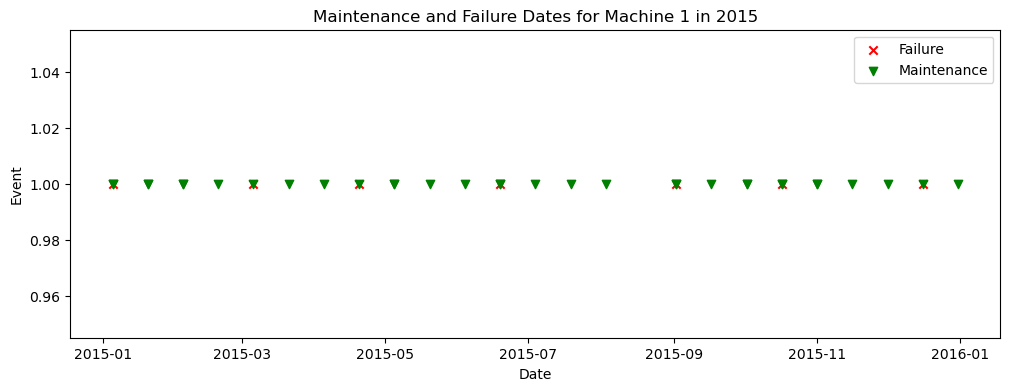

In [9]:
# plot to see the dates of maintenance and error dates and failure dates

# Convert date strings to datetime objects
error_dates_1 = pd.to_datetime(error_dates_1)
failure_dates_1 = pd.to_datetime(failure_dates_1)
maint_dates_1 = pd.to_datetime(maint_dates_1)

plt.figure(figsize=(12, 4))
# Create a plot with blue markers for errors and red markers for failures
#plt.scatter(error_dates_1, [1] * len(error_dates_1), color='blue', marker='o', label='Error')
plt.scatter(failure_dates_1, [1] * len(failure_dates_1), color='red', marker='x', label='Failure')
plt.scatter(maint_dates_1, [1] * len(maint_dates_1), color='green', marker='v', label='Maintenance')

# Set plot labels and legend
plt.xlabel('Date')
plt.ylabel('Event')
plt.title('Maintenance and Failure Dates for Machine 1 in 2015')
plt.legend()

# Show the plot
plt.show()

Plot the telemetry readings around the failure date of one machine and check if there is any anamoly in the readings. 

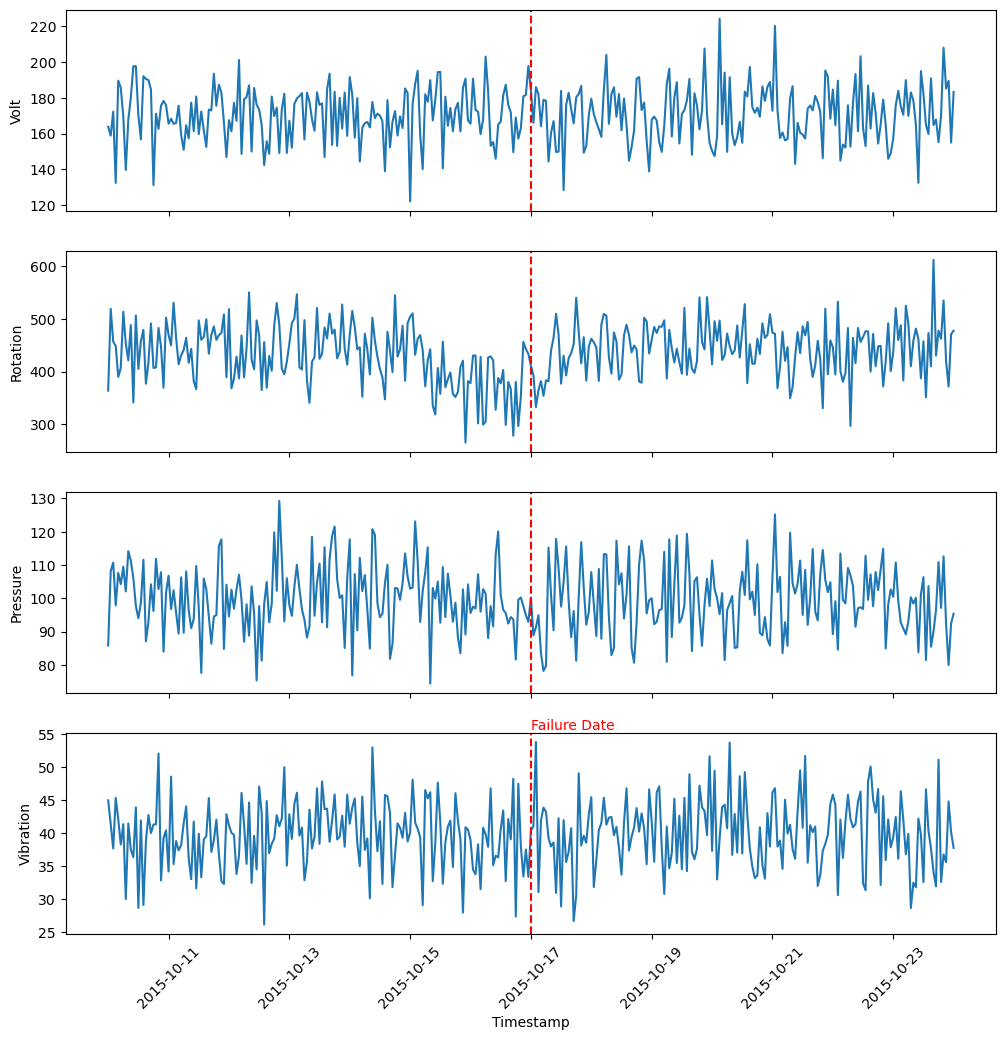

In [10]:
telemetry_1 = telemetry[telemetry['machineID'] == 1]

fail_date = pd.to_datetime('2015-10-17') # Date of failure

date_range = pd.date_range(start=fail_date - pd.Timedelta(days=7), end=fail_date + pd.Timedelta(days=7), freq='H')

telemetry_1_fail = telemetry_1[telemetry_1['datetime'].isin(date_range)]

# Plot volt
fig, ax = plt.subplots(nrows=4, sharex=True, figsize = (12,12))

ax[0].plot('datetime', 'volt', data=telemetry_1_fail)
ax[0].set_ylabel("Volt")

# PLot rotate
ax[1].plot('datetime', 'rotate', data=telemetry_1_fail)
ax[1].set_ylabel("Rotation")


# Plot pressure 
ax[2].plot('datetime', 'pressure', data=telemetry_1_fail)
ax[2].set_ylabel("Pressure")

# Plot vibration 
ax[3].plot('datetime', 'vibration', data=telemetry_1_fail)
ax[3].set_ylabel("Vibration")
ax[3].set_xlabel("Timestamp")
ax[3].tick_params(axis='x', rotation=45)

# Add a red vertical line at the failure date
for a in ax:
    a.axvline(fail_date, color='red', linestyle='--', label='Failure Date')
ax[3].text(fail_date, a.get_ylim()[1], 'Failure Date', color='red', rotation=0, verticalalignment='bottom')

plt.show()

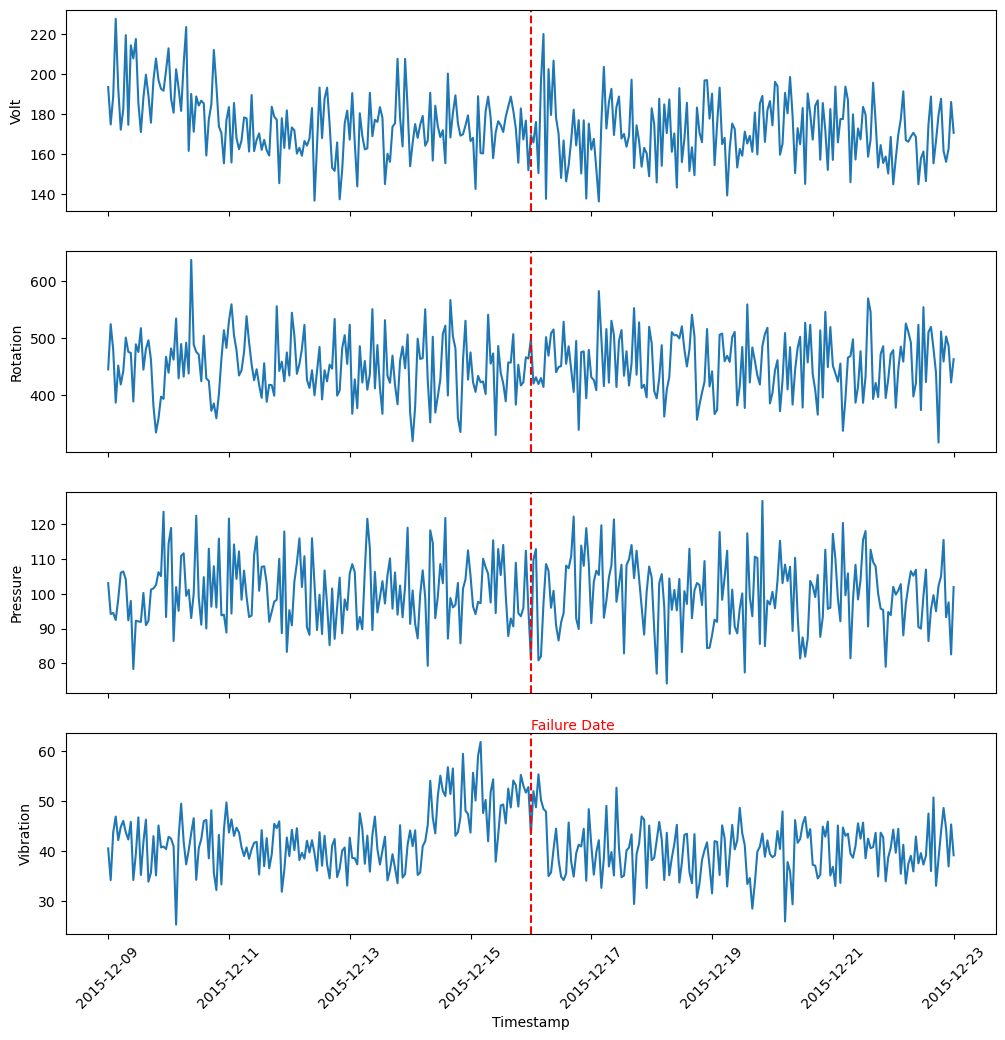

In [11]:
# Same plot for another failure date
telemetry_1 = telemetry[telemetry['machineID'] == 1]

fail_date = pd.to_datetime('2015-12-16') # Date of failure

date_range = pd.date_range(start=fail_date - pd.Timedelta(days=7), end=fail_date + pd.Timedelta(days=7), freq='H')

telemetry_1_fail = telemetry_1[telemetry_1['datetime'].isin(date_range)]

# Plot volt
fig, ax = plt.subplots(nrows=4, sharex=True, figsize = (12,12))

ax[0].plot('datetime', 'volt', data=telemetry_1_fail)
ax[0].set_ylabel("Volt")

# PLot rotate
ax[1].plot('datetime', 'rotate', data=telemetry_1_fail)
ax[1].set_ylabel("Rotation")

# Plot pressure 
ax[2].plot('datetime', 'pressure', data=telemetry_1_fail)
ax[2].set_ylabel("Pressure")

# Plot vibration 
ax[3].plot('datetime', 'vibration', data=telemetry_1_fail)
ax[3].set_ylabel("Vibration")
ax[3].set_xlabel("Timestamp")
ax[3].tick_params(axis='x', rotation=45)

# Add a red vertical line at the failure date
for a in ax:
    a.axvline(fail_date, color='red', linestyle='--', label='Failure Date')
ax[3].text(fail_date, a.get_ylim()[1], 'Failure Date', color='red', rotation=0, verticalalignment='bottom')

plt.show()

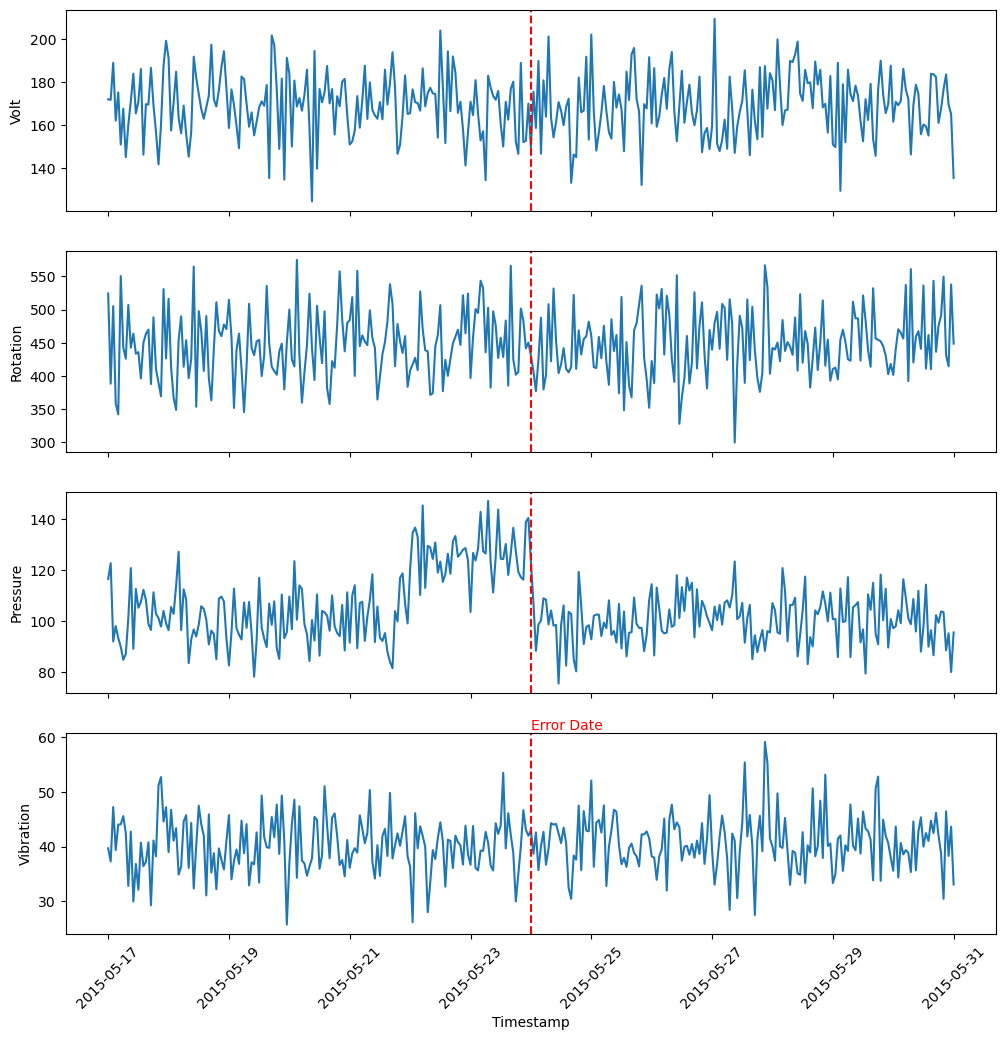

In [12]:
# Similar plot for error date
telemetry_1 = telemetry[telemetry['machineID'] == 1]

error_date = pd.to_datetime('2015-05-24') # Date of error

date_range = pd.date_range(start=error_date - pd.Timedelta(days=7), end=error_date + pd.Timedelta(days=7), freq='H')

telemetry_1_error = telemetry_1[telemetry_1['datetime'].isin(date_range)]

# Plot volt
fig, ax = plt.subplots(nrows=4, sharex=True, figsize = (12,12))

ax[0].plot('datetime', 'volt', data=telemetry_1_error)
ax[0].set_ylabel("Volt")

# PLot rotate
ax[1].plot('datetime', 'rotate', data=telemetry_1_error)
ax[1].set_ylabel("Rotation")

# Plot pressure 
ax[2].plot('datetime', 'pressure', data=telemetry_1_error)
ax[2].set_ylabel("Pressure")

# Plot vibration 
ax[3].plot('datetime', 'vibration', data=telemetry_1_error)
ax[3].set_ylabel("Vibration")
ax[3].set_xlabel("Timestamp")
ax[3].tick_params(axis='x', rotation=45)

# Add a red vertical line at the failure date
for a in ax:
    a.axvline(error_date, color='red', linestyle='--', label='Error Date')
ax[3].text(error_date, a.get_ylim()[1], 'Error Date', color='red', rotation=0, verticalalignment='bottom')

plt.show()

It can be observed there is visible anamoly in atleast one of the telemetry readings when there is an error or failure. 
Diving deep into each telemetry reading to check the stationarity of time series and auto-correlations in the time series.

In [13]:
# set datatime column as index for the time series
telemetry_1 = telemetry[telemetry['machineID'] == 1]
telemetry_1.set_index('datetime',inplace=True)
telemetry_1 = telemetry_1.drop('machineID', axis = 1)
telemetry_1.head()

,volt,rotate,pressure,vibration
datetime,,,,
2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686
2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973
2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847
2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144
2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511


In [14]:
# create  a new column for the difference
telemetry_1['rotate_diff']=telemetry_1['rotate'].diff()
telemetry_1.head()

,volt,rotate,pressure,vibration,rotate_diff
datetime,,,,,
2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,NaN
2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,-15.756589
2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,124.602336
2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,-181.200490
2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,89.227538


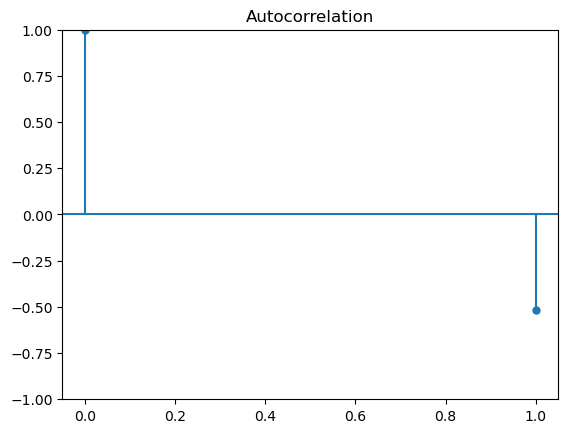

In [15]:
# import autocorrelation function(plt_acf)
from  statsmodels.graphics.tsaplots import plot_acf as plt_acf

# Display autocorrelation of 1000 observations between the time series and its firts time lag(difference)
plt_acf(telemetry_1['rotate_diff'].iloc[1:1000],lags=1)
plt.show()

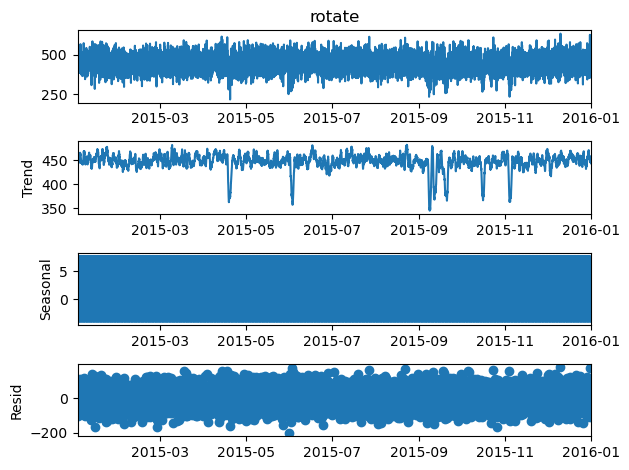

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(telemetry_1['rotate'], model='additive',extrapolate_trend='freq')
components.plot()
plt.show()

In [17]:
# import adfuller function
from statsmodels.tsa.stattools import adfuller

#=============================================
# Build a function to check stationarity
def ISstationarity(df):
    # adfuller(df)[1]:p_value , adf<critical value
       if (adfuller(df)[1]< 0.05) and (adfuller(df)[0] < adfuller(df)[4]['5%']):
        print(' stationary')
       else:
        print('NOT stationary')
#==============================================        
        
#Extract seasonal data        
seasonal = components.seasonal 

#Check stationarity
ISstationarity(seasonal) 

 stationary


### Autoregrssive model

Predicted value for Auto Regression  2015-12-01 01:00:00    440.871790
2015-12-01 02:00:00    449.923546
2015-12-01 03:00:00    446.275810
2015-12-01 04:00:00    449.630383
2015-12-01 05:00:00    451.722528
                          ...    
2016-01-30 21:00:00    446.339335
2016-01-30 22:00:00    446.339335
2016-01-30 23:00:00    446.339335
2016-01-31 00:00:00    446.339335
2016-01-31 01:00:00    446.339335
Freq: H, Length: 1465, dtype: float64


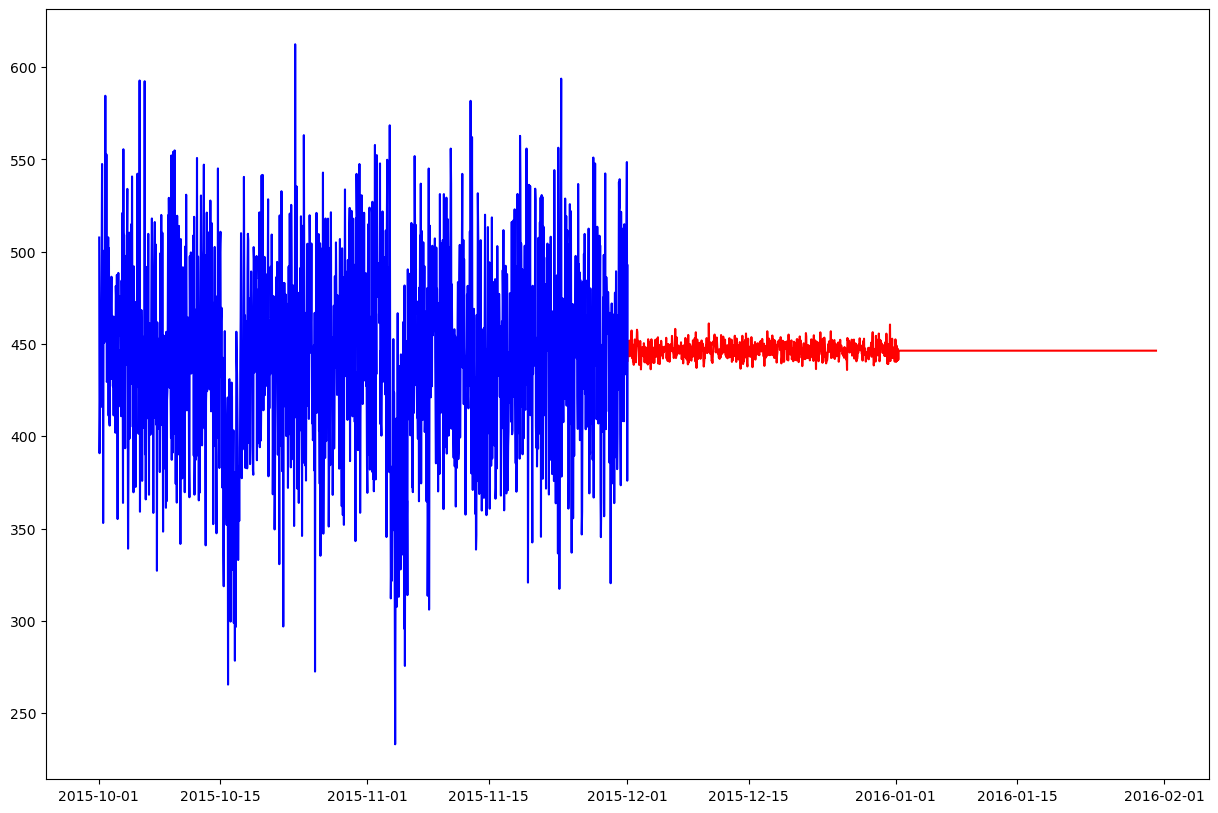

In [18]:
from statsmodels.tsa.ar_model import AutoReg

# Define the model
model = AutoReg(lags=1, endog=telemetry_1['rotate'])
#fit the model
model_fit = model.fit()

#predict 2 month
y_predict = model_fit.predict(start= '2015-12-01 01:00:00', end = '2016-01-31 01:00:00' )
print('Predicted value for Auto Regression ', y_predict)
plt.figure(figsize=(15,10))
plt.plot(y_predict,c='r',)

# Display 2 previous month
plt.plot(telemetry_1['rotate'].loc['2015-10-01 01:00:00':'2015-12-01 01:00:00'],c='b',)
plt.show()

### ARIMA Model

Predicted value for ARIMA  2015-11-01 01:00:00    442.530506
2015-11-01 02:00:00    442.548637
2015-11-01 03:00:00    446.796549
2015-11-01 04:00:00    447.151652
2015-11-01 05:00:00    443.886733
                          ...    
2016-01-31 21:00:00    446.327294
2016-01-31 22:00:00    446.327294
2016-01-31 23:00:00    446.327294
2016-02-01 00:00:00    446.327294
2016-02-01 01:00:00    446.327294
Freq: H, Name: predicted_mean, Length: 2209, dtype: float64


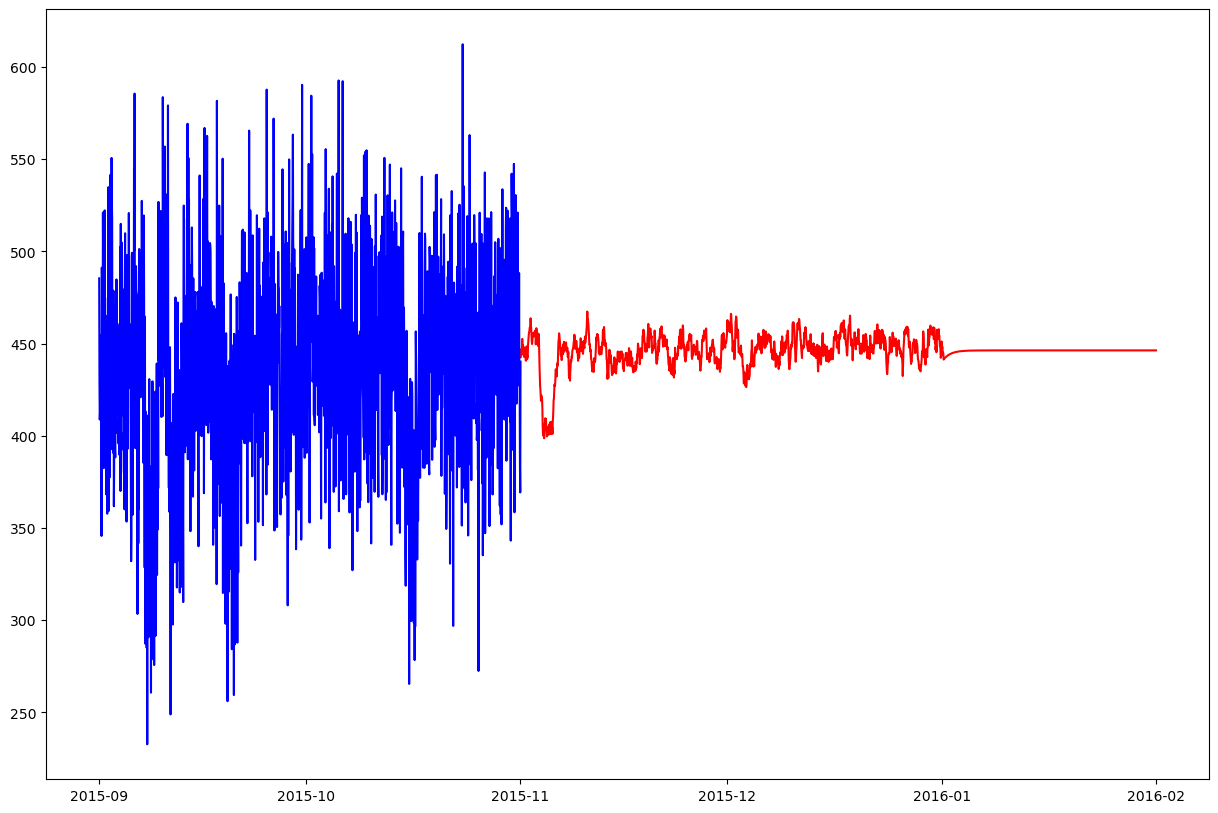

In [19]:
# import ARIMA class
from statsmodels.tsa.arima.model import ARIMA
# Define ARIMA model p=1,d=0 q=1
model = ARIMA(telemetry_1['rotate'], order=(1,0,1))
model_fit = model.fit()
#=================================
# Predict 3 months
y_predict = model_fit.predict( start= '2015-11-01 01:00:00', end = '2016-02-01 01:00:00' )
print('Predicted value for ARIMA ', y_predict)
plt.figure(figsize=(15,10))
plt.plot(y_predict,c='r',)

# Disply 1 month before
plt.plot(telemetry_1['rotate'].loc['2015-9-01 01:00:00':'2015-11-01 01:00:00'],c='b',)
plt.show()

### SARIMAX Model

Predicted value for SARIMAX  2015-11-01 01:00:00    447.952864
2015-11-01 02:00:00    447.537996
2015-11-01 03:00:00    451.038404
2015-11-01 04:00:00    451.151679
2015-11-01 05:00:00    447.959669
                          ...    
2016-01-31 21:00:00    437.474107
2016-01-31 22:00:00    437.465145
2016-01-31 23:00:00    437.456182
2016-02-01 00:00:00    437.447220
2016-02-01 01:00:00    437.438259
Freq: H, Name: predicted_mean, Length: 2209, dtype: float64


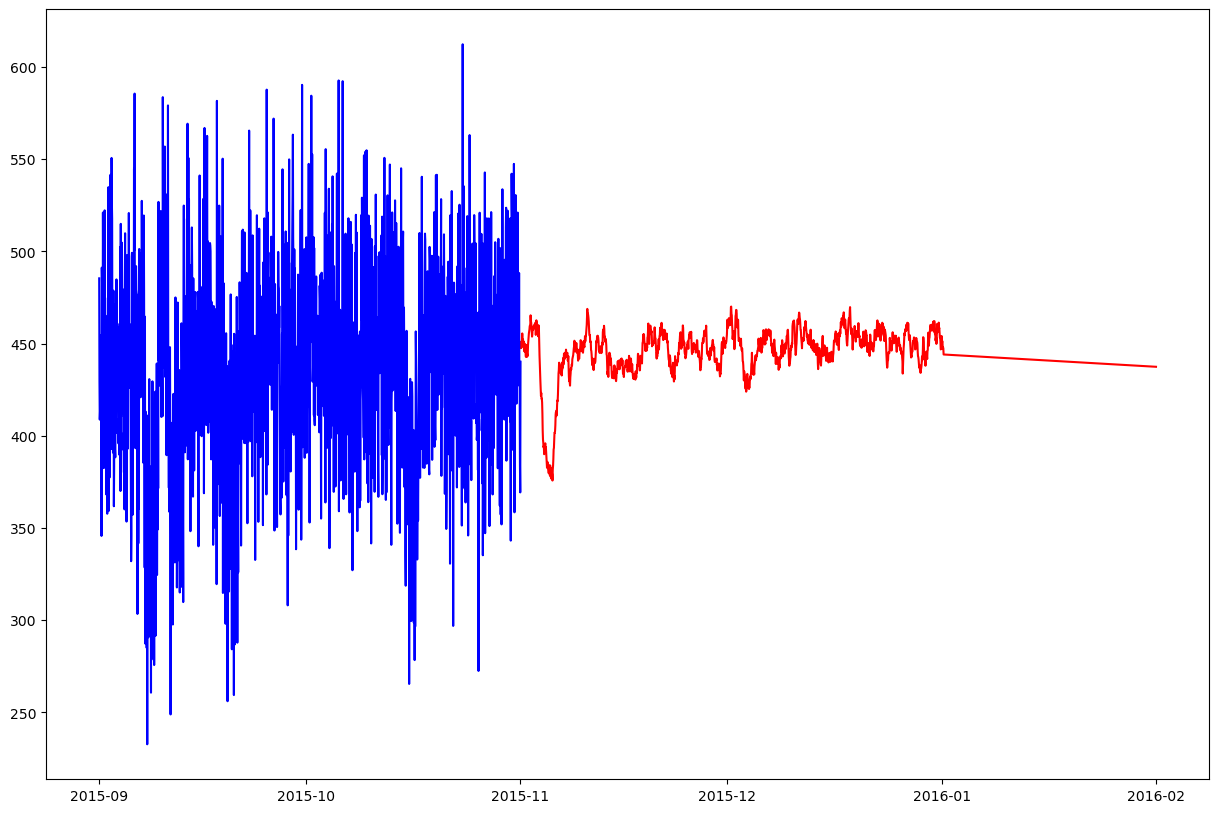

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#define model
model = SARIMAX(telemetry_1['rotate'], order=(1, 0, 1))
#fit model
model_fit = model.fit(disp=False)

#Predict 2 month
y_predict = model_fit.predict( start= '2015-11-01 01:00:00', end = '2016-02-01 01:00:00' )
print('Predicted value for SARIMAX ', y_predict)
plt.figure(figsize=(15,10))
plt.plot(y_predict,c='r',)

# Display 1 month before
plt.plot(telemetry_1['rotate'].loc['2015-9-01 01:00:00':'2015-11-01 01:00:00'],c='b',)
plt.show()

It can be seen that fit of ARIMA model is slightly better than the other two models. Let us define a function to fit the telemetry readings of all machines using ARIMA models and another function to forecast the data for next five days i.e, from 2016-01-01 to 2016-01-06.

In [21]:
def parameter_search(ts):
    # Define the parameter grids
    p_values = range(0, 3)
    d_values = [0]  # No differencing
    q_values = range(0, 3)

    # Create a list to store the results
    results = []

    # Set up time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Perform grid search
    for p in p_values:
        for q in q_values:
            mse_scores = []  # Store MSE scores for each split

            # Time series cross-validation
            for train_index, test_index in tscv.split(ts):
                train, test = ts.iloc[train_index], ts.iloc[test_index]

                # Fit ARIMA model
                model = ARIMA(train, order=(p, 0, q))
                model_fit = model.fit()

                # Make predictions on the test set
                predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

                # Calculate MSE and store it
                mse = mean_squared_error(test, predictions)
                mse_scores.append(mse)

            # Calculate mean MSE for the current (p, q) combination
            mean_mse = np.mean(mse_scores)

            # Append results to the list
            results.append({'p': p, 'q': q, 'mse': mean_mse})

    # Find the best (p, q) combination with the lowest MSE
    best_params = min(results, key=lambda x: x['mse'])

    print("Best (p, q) combination:", best_params)
    
    return best_params

In [22]:
def forecast(ts):
    # get the best ARIMA parameters
    arima_params = parameter_search(ts)
    #arima_params = {'p': 1, 'q': 1}
    # Fit the ARIMA model using the entire training data and the best params
    model = ARIMA(ts, order=(arima_params['p'], 0, arima_params['q']))
    model_fit = model.fit()
    
    # Forecast the telemetry readings for the next two months and return
    predicted_readings = model_fit.predict(start= '2015-12-01 01:00:00', end = '2016-01-06 06:00:00')
    
    return predicted_readings

In [23]:
forecast(telemetry_1['vibration']).tolist()[-120:]

Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 30.54900272801738}


[40.51596933847271,
 40.43884516278738,
 40.51207242406285,
 40.453973835791544,
 40.51026693200187,
 40.46661230020175,
 40.50998705138346,
 40.477291919496864,
 40.51080597062438,
 40.48642065984831,
 40.51240243632483,
 40.494312383268735,
 40.51453531856466,
 40.50120914967682,
 40.51702426794443,
 40.5072981984931,
 40.51973500744204,
 40.51272488104481,
 40.52256815048434,
 40.51760251118289,
 40.52545070168769,
 40.52201987028207,
 40.528329598411325,
 40.52604692683843,
 40.531166804739186,
 40.52973919698465,
 40.53393558628728,
 40.533141070355654,
 40.53661768309606,
 40.53628834820564,
 40.53920116548444,
 40.53921018167853,
 40.541678809193606,
 40.541930553238025,
 40.54404686529877,
 40.54446941009877,
 40.54630413015688,
 40.54684353250163,
 40.54845124332487,
 40.54906719989176,
 40.55049015863054,
 40.551152703001705,
 40.55242374670056,
 40.55311073838462,
 40.5542554972354,
 40.554950713222304,
 40.55598929691714,
 40.55668098159718,
 40.55762926461661,
 40.55830902

Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 120.61551505388839}


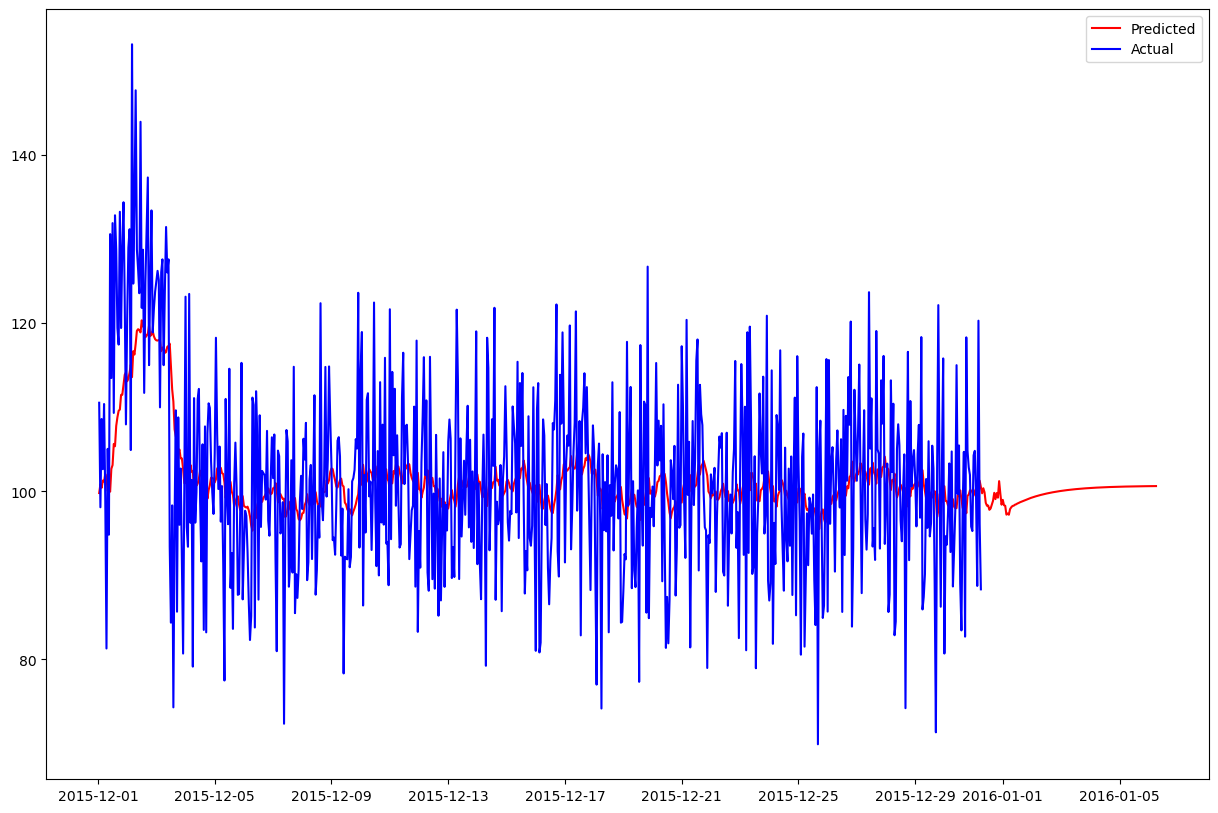

In [30]:
plt.figure(figsize=(15,10))
plt.plot(forecast(telemetry_1['pressure']), c='r', label = 'Predicted')

# Disply 1 month before
plt.plot(telemetry_1['pressure'].loc['2015-12-01 01:00:00':'2015-12-31 06:00:00'],c='b', label = 'Actual')
plt.legend()
plt.show()

Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 30.54900272801738}


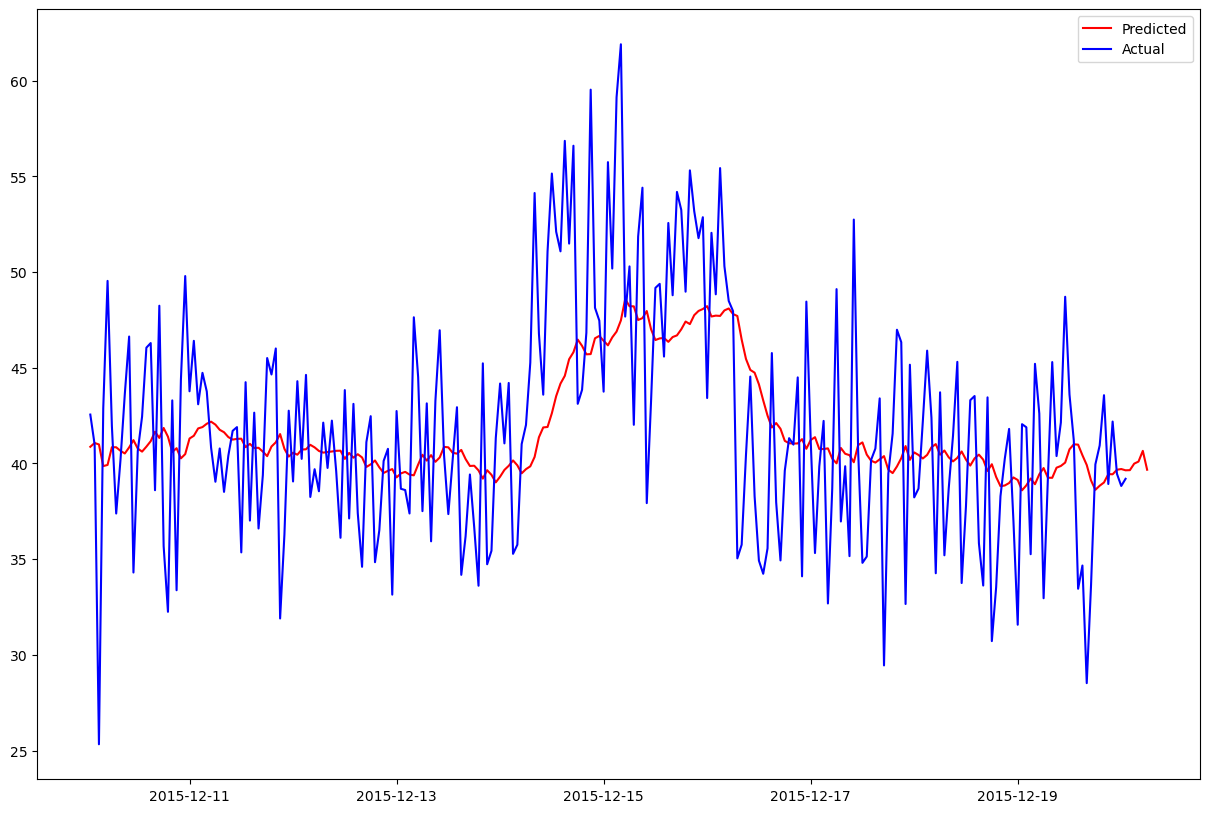

In [36]:
# Plotting the vibration forecast values of machine 1 against the actual values around the failure date '2015-12-15'
ts = telemetry_1['vibration']

arima_params = parameter_search(ts)
# Fit the ARIMA model using the entire training data and the best params
model = ARIMA(ts, order=(arima_params['p'], 0, arima_params['q']))
model_fit = model.fit()
    
# Forecast the telemetry readings
predicted_readings = model_fit.predict(start= '2015-12-10 01:00:00', end = '2015-12-20 06:00:00')

plt.figure(figsize=(15,10))
plt.plot(predicted_readings, c='r', label = 'Predicted')

# Disply 1 month before
plt.plot(telemetry_1['vibration'].loc['2015-12-10 01:00:00':'2015-12-20 01:00:00'],c='b', label = 'Actual')
plt.legend()
plt.show()

In [25]:
readings = ['volt', 'rotate', 'pressure', 'vibration']

forecast_data_1 = pd.DataFrame()
start_time = pd.to_datetime('2016-01-01 07:00:00')
end_time = pd.to_datetime('2016-01-06 06:00:00')
forecast_data_1['datetime'] = pd.date_range(start=start_time, end=end_time, freq='H')
forecast_data_1['machineID'] = 1

for var in readings:
    forecast_data_1[var] = forecast(telemetry_1[var]).tolist()[-120:]

forecast_data_1

Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 233.09049108039602}
Best (p, q) combination: {'p': 1, 'q': 2, 'mse': 2814.4072606457703}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 120.61551505388839}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 30.54900272801738}


,datetime,machineID,volt,rotate,pressure,vibration
0,2016-01-01 07:00:00,1,170.882407,442.098538,98.108723,40.515969
1,2016-01-01 08:00:00,1,170.879874,441.104875,98.256143,40.438845
2,2016-01-01 09:00:00,1,170.877450,441.328949,98.292459,40.512072
3,2016-01-01 10:00:00,1,170.875132,441.543416,98.406228,40.453974
4,2016-01-01 11:00:00,1,170.872914,441.748690,98.457813,40.510267
...,...,...,...,...,...,...
115,2016-01-06 02:00:00,1,170.824381,446.296428,100.618199,40.581245
116,2016-01-06 03:00:00,1,170.824365,446.297946,100.619832,40.581357
117,2016-01-06 04:00:00,1,170.824351,446.299398,100.621410,40.581466
118,2016-01-06 05:00:00,1,170.824337,446.300788,100.622934,40.581571


In [28]:
# Getting the telemetry readings for machine 5
telemetry_5 = telemetry[telemetry['machineID']==5].reset_index()
telemetry_5.set_index('datetime',inplace=True)
telemetry_5 = telemetry_5.drop('machineID', axis = 1)

forecast_data_5 = pd.DataFrame()
start_time = pd.to_datetime('2016-01-01 07:00:00')
end_time = pd.to_datetime('2016-01-06 06:00:00')
forecast_data_5['datetime'] = pd.date_range(start=start_time, end=end_time, freq='H')
forecast_data_5['machineID'] = 1

for var in readings:
    forecast_data_5[var] = forecast(telemetry_5[var]).tolist()[-120:]

forecast_data_5['model'] = 'model3'
forecast_data_5['age'] = 2
forecast_data_5['errorID'] = 'none'
forecast_data_5.to_csv('forecast_data_5.csv')

Best (p, q) combination: {'p': 2, 'q': 0, 'mse': 240.97681610173444}
Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 2752.0685564277355}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 134.80799143117798}
Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 27.449974415749853}


In [26]:
forecast_data_1['model'] = 'model3'
forecast_data_1['age'] = 18
forecast_data_1['errorID'] = 'none'

## Forecasting the telemetry readings for all machines

In [31]:
forecast_data = pd.DataFrame(columns = ['datetime', 'machineID', 'volt', 'rotate', 
                                        'pressure', 'vibration', 'model', 'age', 'errorID'])

start_time = pd.to_datetime('2016-01-01 07:00:00')
end_time = pd.to_datetime('2016-01-06 06:00:00')

for i in range(1,51):
    temp = telemetry[telemetry['machineID']==i].reset_index()
    temp.set_index('datetime',inplace=True)
    temp = temp.drop('machineID', axis = 1)
    
    temp_forecast = pd.DataFrame()
    temp_forecast['datetime'] = pd.date_range(start=start_time, end=end_time, freq='H')
    
    temp_forecast['machineID'] = i
    
    for var in readings:
        temp_forecast[var] = forecast(temp[var]).tolist()[-120:]
        
    temp_forecast['model'] = machines[machines['machineID']==i]['model'].tolist()[0]
    temp_forecast['age'] = machines[machines['machineID']==i]['age'].tolist()[0]
    temp_forecast['errorID'] = 'none'
    
    forecast_data = pd.concat([forecast_data, temp_forecast], axis=0, ignore_index=True)
    
forecast_data.to_csv('forecast_data.csv')

Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 233.09049108039602}
Best (p, q) combination: {'p': 1, 'q': 2, 'mse': 2814.4072606457703}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 120.61551505388839}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 30.54900272801738}
Best (p, q) combination: {'p': 0, 'q': 1, 'mse': 243.87483987189813}
Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 2807.830665153291}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 113.6427622083418}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 28.387239774925064}
Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 233.57656130716464}
Best (p, q) combination: {'p': 2, 'q': 1, 'mse': 2834.8068819044797}
Best (p, q) combination: {'p': 2, 'q': 1, 'mse': 118.36509109296989}
Best (p, q) combination: {'p': 0, 'q': 0, 'mse': 28.094914641462857}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 236.2940140214383}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 2830.7223167360085}
Best (p, q) combination: {'p': 1, 'q':

Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 257.07692313593805}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 2798.82522367575}
Best (p, q) combination: {'p': 0, 'q': 0, 'mse': 134.52583992635712}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 28.798706113346192}
Best (p, q) combination: {'p': 0, 'q': 2, 'mse': 244.3786664756467}
Best (p, q) combination: {'p': 1, 'q': 1, 'mse': 2793.3277599688467}
Best (p, q) combination: {'p': 2, 'q': 2, 'mse': 116.99903423167825}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 30.61834807555516}
Best (p, q) combination: {'p': 1, 'q': 2, 'mse': 241.12617734395727}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 2856.2458232224794}
Best (p, q) combination: {'p': 2, 'q': 1, 'mse': 111.15008358067719}
Best (p, q) combination: {'p': 1, 'q': 0, 'mse': 30.54187513559118}
Best (p, q) combination: {'p': 0, 'q': 2, 'mse': 251.94845937661165}
Best (p, q) combination: {'p': 2, 'q': 0, 'mse': 2777.7852013195698}
Best (p, q) combination: {'p': 0, 'q': 

This data is used in Equipment_Failure_classification to predict the failure of all machines in the next 5 days.